## Introduction

A customer of mine would like to open an Seafood Restaurant in Arhus, Denmark. He work in the seafood business in the Faroe Islands and want to sell their best products seafood to Denmark. As young I studied in Aarhus and like the atmosphere of the town centre, so I have recommended that my customer finds a location in Aarhus, Denmark.

I will try to find a spot for his seafood restaurant from several criteria:
1. That is there must be some interesting venues close to it. That is, it must be located in an area belonging to the right cluster.
2. It should be far away from other seafood restaurants
3. It should be in an area without many other food venues

I will make visualize all food venues and all seafood restaurants and find spots that fullfill criterias 2. and 3. 

To obtain criteria 1, I will separate Aarhus center in a mesh of neighbourhoods around 300 metres wide. I will look at the different neighbourhoods to see wich ones are similar in order to find a suitable location. Specifically I will make a clustering of the neighbourhoods based on venues. For instance if there are clusters with theaters or cinemas in them. I will make an k-means clustering analysis using Foursquare API.  

## Data

In order to make our analysis we need to obtain some data:
- We need to construct a mesh of areas covering the center of Aarhus, Denmark
- From these locations we obtain Forusquare venue data of food venues and seafood restaurant venues, and visualize them

### We find the center of Aarhus (Arhus Cathedral)

First we import packages to handle folium.

In [1]:
import requests
#!pip install geopy

from geopy.geocoders import Nominatim
geolocator = Nominatim()
adresse = 'Aarhus Domkirke'
try:
    location = geolocator.geocode(adresse)
    print('Arhus Centrum is in ', location.latitude, location.longitude)
except:
    print(adresse)
aarhus_centrum = [location.latitude, location.longitude]
print(aarhus_centrum)

/resources/common/.virtualenv/python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


Arhus Centrum is in  56.15685435 10.2106463239974
[56.15685435, 10.2106463239974]


### We make a mesh of neighbourhoods

#### First we convert from latitude/longitude to cartesian measures

In [2]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Aarhus Centrum longitude={}, latitude={}'.format(aarhus_centrum[1], aarhus_centrum[0]))
x, y = lonlat_to_xy(aarhus_centrum[1], aarhus_centrum[0])
print('Aarhus centrum UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Aarhus centrum longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
Aarhus Centrum longitude=10.2106463239974, latitude=56.15685435
Aarhus centrum UTM X=202641.0637672961, Y=6233869.4107194785
Aarhus centrum longitude=10.210646323997398, latitude=56.15685435000001


#### Then we construct the neighbourhood centers

In [3]:
aarhus_centrum_x, aarhus_centrum_y = lonlat_to_xy(aarhus_centrum[1], aarhus_centrum[0]) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = aarhus_centrum_x - 1800  # we start 1.800 metres from the center
x_step = 300
y_min = aarhus_centrum_y - 1800 - (int(22/k)*k*300 - 3600)/2
y_step = 300 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(22/k)):
    y = y_min + i * y_step
    x_offset = 150 if i%2==0 else 0
    for j in range(0, 10):                      # the steps stop at 10 because wa have seawater to the east
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(aarhus_centrum_x, aarhus_centrum_y, x, y)
        if (distance_from_center <= 1801):      # only append points within the 1.800 meter radius
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighbourhood centers generated.')

116 candidate neighbourhood centers generated.


#### The neighbourhood centers are plotted

In [4]:
#!pip install folium
import folium

In [5]:
map_aarhus = folium.Map(location=aarhus_centrum, zoom_start=13)
folium.Marker(aarhus_centrum, popup='Aarhus Domkirke').add_to(map_aarhus)
for lat, lon in zip(latitudes, longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_aarhus) 
map_aarhus

#### The locations are imported to a dataframe

In [6]:
import pandas as pd

df_locations = pd.DataFrame({'Neighbourhood Latitude': latitudes,
                             'Neighbourhood Longitude': longitudes,
                             'X': xs,
                             'Y': ys})

df_locations.head()

,Neighbourhood Latitude,Neighbourhood Longitude,X,Y
0,56.141454,10.205314,202191.063767,6.232181e+06
1,56.141641,10.210125,202491.063767,6.232181e+06
2,56.141828,10.214936,202791.063767,6.232181e+06
3,56.142014,10.219747,203091.063767,6.232181e+06
4,56.143499,10.197807,201741.063767,6.232440e+06


### Foursquare venue information is collected

#### We set up to import Foursquare venue information

In [7]:
CLIENT_ID = '1APIKEUUY3N0O0CG22IPYPWFVL33NLZPJN4RVSHXBO315QIS' # your Foursquare ID
CLIENT_SECRET = 'Y21WCG50Q5S4VLNYQOFIUQ1IHBSQTDUWLDS0NVQX1QBXIDQU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

food_category = '4d4b7105d754a06374d81259'
seafood_category = '4bf58dd8d48988d1ce941735'

#!pip install foursquare
import foursquare
from pandas.io.json import json_normalize

Your credentails:
CLIENT_ID: 1APIKEUUY3N0O0CG22IPYPWFVL33NLZPJN4RVSHXBO315QIS
CLIENT_SECRET:Y21WCG50Q5S4VLNYQOFIUQ1IHBSQTDUWLDS0NVQX1QBXIDQU


#### We make a function to call the Foursquare venue information

In [8]:
def getNearbyVenues(latitudes, longitudes, category, radius=170, LIMIT=100):  #radius = 170 to get an overlap
    venues_list=[]
    for lat, lng in zip(latitudes, longitudes):
        #print(lat)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            category,
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### We find all food related venues

In [9]:
food_venues = getNearbyVenues(latitudes, longitudes, food_category)
food_venues.head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,56.143499,10.197807,Go' Kaffe,56.144753,10.198304,Café
1,56.143687,10.202619,Marselis Pizzeria,56.143119,10.205162,Pizza Place
2,56.143874,10.207430,Aspendos,56.143428,10.205480,Pizza Place
3,56.143874,10.207430,Marselis Pizzeria,56.143119,10.205162,Pizza Place
4,56.145732,10.195111,GLAD!,56.146910,10.194773,Salad Place


In [12]:
seafood_venues = getNearbyVenues(latitudes, longitudes, seafood_category)
seafood_venues.head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,56.157830,10.205688,Gambas,56.158891,10.206710,Seafood Restaurant
1,56.157830,10.205688,Sushimania,56.158264,10.207182,Seafood Restaurant
2,56.158017,10.210501,Restaurant Pihlkjær,56.158595,10.212578,Seafood Restaurant
3,56.160250,10.207805,Klassisk Fisk,56.160552,10.209099,Seafood Restaurant
4,56.160250,10.207805,Gambas,56.158891,10.206710,Seafood Restaurant


### Food venues and seafood restaurants are plotted (seafood restaurants are red)

In [13]:
map_aarhus = folium.Map(location=aarhus_centrum, zoom_start=14)
folium.Marker(aarhus_centrum, popup='Aarhus Domkirke').add_to(map_aarhus)
for res in food_venues.values:
    lat = res[3]; lon = res[4]
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_aarhus) 
for res in seafood_venues.values:
    lat = res[3]; lon = res[4]
    folium.CircleMarker([lat, lon], radius=2, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_aarhus)   
map_aarhus

#### And the same map with the areas

In [14]:
map_aarhus = folium.Map(location=aarhus_centrum, zoom_start=14)
folium.Marker(aarhus_centrum, popup='Aarhus Domkirke').add_to(map_aarhus)
for res in food_venues.values:
    lat = res[3]; lon = res[4]
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_aarhus) 
for res in seafood_venues.values:
    lat = res[3]; lon = res[4]
    folium.CircleMarker([lat, lon], radius=2, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_aarhus)   
for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat, lon], radius=150, color='grey', fill=False).add_to(map_aarhus)
map_aarhus

### At end we find all venues in each area

In [15]:
def getAllNearbyVenues(latitudes, longitudes, radius=170, LIMIT=100):  #radius = 170 to get an overlap
    venues_list=[]
    for lat, lng in zip(latitudes, longitudes):
        #print(lat)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

all_venues = getAllNearbyVenues(latitudes, longitudes)
all_venues.head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,56.143499,10.197807,Ingerslev Marked,56.144833,10.196892,Farmers Market
1,56.143499,10.197807,Aarhus Svømmestadion,56.143656,10.196837,Gym Pool
2,56.143499,10.197807,ASA Boldbaner,56.143486,10.197621,Soccer Field
3,56.143499,10.197807,Frederiksbjerg Hallen,56.143818,10.196807,Stadium
4,56.143499,10.197807,Go' Kaffe,56.144753,10.198304,Café


These venues we will use to make a k-means cluster analysis of all the neighbourhoods. All venues are visualized in the map below.

In [16]:
map_aarhus = folium.Map(location=aarhus_centrum, zoom_start=14)
folium.Marker(aarhus_centrum, popup='Aarhus Domkirke').add_to(map_aarhus)
for res in all_venues.values:
    lat = res[3]; lon = res[4]
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_aarhus) 
for res in seafood_venues.values:
    lat = res[3]; lon = res[4]
    folium.CircleMarker([lat, lon], radius=2, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_aarhus)   
map_aarhus

## Analysis

 - Make a k-means analysis. Analyse the clusters, in order to find a suitable cluster to locate a new seafood restaurant. 
 - Find a spot away fram other seafood restaurants.
 - Find a spot not crowded with food venues.

### Hot encoding

In [17]:
# one hot encoding
aarhus_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

In [18]:
# add neighbourhood column back to dataframe
aarhus_onehot['Neighbourhood Latitude'] = all_venues['Neighbourhood Latitude'] 

In [19]:
# move neighbourhood column to the first column
fixed_columns = [aarhus_onehot.columns[-1]] + list(aarhus_onehot.columns[:-1])
aarhus_onehot = aarhus_onehot[fixed_columns]

In [20]:
# Normalize the data
aarhus_grouped = aarhus_onehot.groupby('Neighbourhood Latitude').mean().reset_index()

In [21]:
#Frequency of top 10 venues
num_top_venues = 10

for hood in aarhus_grouped['Neighbourhood Latitude']:
    print("----"+str(hood)+"----")
    temp = aarhus_grouped[aarhus_grouped['Neighbourhood Latitude'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----56.14349921975371----
            venue  freq
0    Soccer Field   0.2
1            Café   0.2
2         Stadium   0.2
3        Gym Pool   0.2
4  Farmers Market   0.2
5      Playground   0.0
6     Pizza Place   0.0
7            Pier   0.0
8        Pharmacy   0.0
9     Music Venue   0.0


----56.14368651429262----
                   venue  freq
0            Pizza Place   0.5
1   Gym / Fitness Center   0.5
2    American Restaurant   0.0
3            Music Venue   0.0
4                   Pool   0.0
5                  Plaza   0.0
6             Playground   0.0
7                   Pier   0.0
8               Pharmacy   0.0
9  Performing Arts Venue   0.0


----56.14387362193484----
                   venue  freq
0            Pizza Place  0.50
1              Jazz Club  0.25
2             Playground  0.25
3    American Restaurant  0.00
4            Music Venue  0.00
5                   Pool  0.00
6                  Plaza  0.00
7                   Pier  0.00
8               Pharmacy  0.00
9  

As we can see there are neighbourhoods with very few venues in them. 

### We run the k-means algorithm for different number of k's 

In [22]:
# Define function that return most common venues 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
from pylab import *

In [23]:
# Top 10 venues are returned
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood Latitude']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood Latitude'] = aarhus_grouped['Neighbourhood Latitude']

for ind in np.arange(aarhus_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(aarhus_grouped.iloc[ind, :], num_top_venues)
    
aarhus_grouped_clustering = aarhus_grouped.drop('Neighbourhood Latitude', 1)

#### The graphs of the two different number of top venues are plotted

In [24]:
# import k-means from clustering stage
from sklearn.cluster import KMeans


The graphs show sum of squared distances from the centroids for different k's. One graph is for 'top 10 venues' and the other for 'top 5 venues'. 

In [25]:
sse = []
list_k = list(range(1, 30))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(aarhus_grouped_clustering)
    sse.append(km.inertia_)

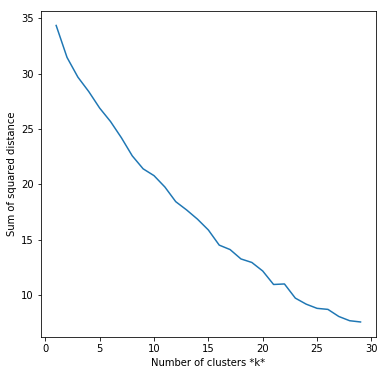

In [26]:
import matplotlib.pyplot as plt
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)   #, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

There is no "elbow" on the graph, so it is difficult to see an optimal number for 'k'. We shall use the clusters to find a good placement for a restaurant, so the number of clusters must not be too small. On the other hand it makes no sence to have too many clusters. There fore I will settle for 10 clusters.

### Wa make 10 clusters based on top 10 venues in each neighbourhood

In [27]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(aarhus_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 3, 7, 4, 5, 5, 5, 9, 5, 5], dtype=int32)

In [28]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

aarhus_merged = df_locations

# merge aarhus_grouped with aarhus_data to add latitude/longitude for each neighbourhood
aarhus_merged = aarhus_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood Latitude'), on='Neighbourhood Latitude')

In [29]:
# Neighbourhoods that not are assigned to any cluster are omitted
aarhus_merged = aarhus_merged.dropna()

In [30]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=aarhus_centrum, zoom_start=14)
folium.Marker(aarhus_centrum, popup='Aarhus Domkirke').add_to(map_aarhus)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(aarhus_merged['Neighbourhood Latitude'], aarhus_merged['Neighbourhood Longitude'], aarhus_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=140,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 0

This cluster is a 'park' cluster and probably not suitable for our restaurant.

In [31]:
aarhus_merged.loc[aarhus_merged['Cluster Labels'] == 0, aarhus_merged.columns[[1] + list(range(5, aarhus_merged.shape[1]))]]

,Neighbourhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
86,10.187969,Park,Wine Bar,Department Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio
90,10.207224,Park,Wine Bar,Department Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio
105,10.201829,Park,Wine Bar,Department Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio


### Cluster 1

This cluster is a 'park' cluster and probably not suitable for our restaurant.

In [32]:
aarhus_merged.loc[aarhus_merged['Cluster Labels'] == 1, aarhus_merged.columns[[1] + list(range(5, aarhus_merged.shape[1]))]]

,Neighbourhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,10.189135,Arts & Entertainment,Restaurant,Grocery Store,Wine Bar,French Restaurant,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market
73,10.212618,French Restaurant,Salad Place,Restaurant,Mexican Restaurant,Bar,Fast Food Restaurant,Flea Market,Fishing Spot,Fish Market,Film Studio
83,10.214735,Plaza,Design Studio,Restaurant,Bar,Fast Food Restaurant,French Restaurant,Dessert Shop,Discount Store,Event Space,Falafel Restaurant
95,10.190084,Restaurant,Wine Bar,French Restaurant,Design Studio,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant


### Cluster 2

This cluster is close to the harbour. There are several wine bars in the area. Even though there is french restaurants in the area I think this is not a good location for our seafood restaurant.

In [33]:
aarhus_merged.loc[aarhus_merged['Cluster Labels'] == 2, aarhus_merged.columns[[1] + list(range(5, aarhus_merged.shape[1]))]]

,Neighbourhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,10.225519,Harbor / Marina,Wine Bar,Furniture / Home Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio
93,10.221666,Harbor / Marina,Fish Market,French Restaurant,Wine Bar,Furniture / Home Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market
102,10.223783,Harbor / Marina,Sports Club,Athletics & Sports,Fishing Spot,Wine Bar,Film Studio,Food Court,Flea Market,Fish Market,Farmers Market
109,10.221087,Harbor / Marina,Scenic Lookout,Wine Bar,French Restaurant,Design Studio,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market


### Cluster 3

In this cluster we see Gym/Fitness Centers as most common venues. Also it is vera far from town center. Probably not an interesting spot for our restaurant.

In [34]:
aarhus_merged.loc[aarhus_merged['Cluster Labels'] == 3, aarhus_merged.columns[[1] + list(range(5, aarhus_merged.shape[1]))]]

,Neighbourhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,10.202619,Pizza Place,Gym / Fitness Center,Wine Bar,French Restaurant,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
48,10.184322,Gym / Fitness Center,Wine Bar,Furniture / Home Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio
94,10.226480,Gym / Fitness Center,Wine Bar,Furniture / Home Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio


### Cluster 4

There is not much more than a plaza at this venue. There it is omitted.

In [35]:
aarhus_merged.loc[aarhus_merged['Cluster Labels'] == 4, aarhus_merged.columns[[1] + list(range(5, aarhus_merged.shape[1]))]]

,Neighbourhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,10.1903,Plaza,Wine Bar,Department Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio


### Cluster 5

In this cluster we see "normal" venues for a town center. Most common venues are shops, hotels, eateries and cafes. This cluster is placed in the center of Aarhus. This area could be a good placement for the seafood restaurant, but a drawback could be that the area is crowded with restaurants. 

In [36]:
aarhus_merged.loc[aarhus_merged['Cluster Labels'] == 5, aarhus_merged.columns[[1] + list(range(5, aarhus_merged.shape[1]))]]

,Neighbourhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,10.197807,Café,Soccer Field,Gym Pool,Stadium,Farmers Market,Film Studio,Flea Market,Fishing Spot,Fish Market,Wine Bar
12,10.195111,Plaza,Italian Restaurant,Farmers Market,Salad Place,Music Store,Food Court,Design Studio,Dessert Shop,Discount Store,Event Space
13,10.199922,Skate Park,Bar,Pub,Café,Food Court,Flea Market,Fishing Spot,Fish Market,Film Studio,Fast Food Restaurant
14,10.204734,Dessert Shop,Coffee Shop,Bakery,Grocery Store,Park,French Restaurant,Discount Store,Event Space,Falafel Restaurant,Farmers Market
22,10.197226,Café,Grocery Store,Vegetarian / Vegan Restaurant,Scandinavian Restaurant,Italian Restaurant,Coffee Shop,Greek Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Fishing Spot
23,10.202038,Café,Bakery,Coffee Shop,American Restaurant,Beer Bar,Japanese Restaurant,Grocery Store,French Restaurant,Cocktail Bar,Scandinavian Restaurant
24,10.206849,Bookstore,Clothing Store,Cosmetics Shop,Gym / Fitness Center,Juice Bar,Sandwich Place,Flea Market,Fishing Spot,Fish Market,Film Studio
25,10.211661,Scandinavian Restaurant,Wine Bar,French Restaurant,Design Studio,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
30,10.189717,Flea Market,Wine Bar,Department Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio
32,10.199341,Hotel,Bus Stop,Middle Eastern Restaurant,Supermarket,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Furniture / Home Store,Film Studio


### Cluster 6

This is the landing quay area, and is not suitable for our restaurant.

In [37]:
aarhus_merged.loc[aarhus_merged['Cluster Labels'] == 6, aarhus_merged.columns[[1] + list(range(5, aarhus_merged.shape[1]))]]

,Neighbourhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
66,10.224941,Boat or Ferry,Garden,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish Market
75,10.222245,Boat or Ferry,Harbor / Marina,Coffee Shop,Garden,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio
76,10.227058,Boat or Ferry,Café,Garden,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish Market


### Cluster 7

This is a shopping cluster - therefore not very interesting for a restaurant.

In [38]:
aarhus_merged.loc[aarhus_merged['Cluster Labels'] == 7, aarhus_merged.columns[[1] + list(range(5, aarhus_merged.shape[1]))]]

,Neighbourhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,10.207430,Pizza Place,Playground,Jazz Club,Wine Bar,French Restaurant,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market
88,10.197596,Pizza Place,Wine Bar,Department Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio
113,10.208760,Cosmetics Shop,Grocery Store,Wine Bar,Furniture / Home Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
115,10.218390,Pizza Place,Grocery Store,Café,Paper / Office Supplies Store,Wine Bar,French Restaurant,Discount Store,Event Space,Falafel Restaurant,Farmers Market


### Cluster 8

The only thing in this cluster is a beer garden, and this is the univercity campus of Aarhus. Not interesting for a restaurant.

In [39]:
aarhus_merged.loc[aarhus_merged['Cluster Labels'] == 8, aarhus_merged.columns[[1] + list(range(5, aarhus_merged.shape[1]))]]

,Neighbourhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
97,10.199712,Beer Garden,Wine Bar,Garden,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio


### Cluster 9

A playground area is not a good location.

In [40]:
aarhus_merged.loc[aarhus_merged['Cluster Labels'] == 9, aarhus_merged.columns[[1] + list(range(5, aarhus_merged.shape[1]))]]

,Neighbourhood Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,10.209545,Playground,Wine Bar,Department Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio
82,10.209921,Playground,Gym,Wine Bar,French Restaurant,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
103,10.192200,Gym,Wine Bar,Furniture / Home Store,Dessert Shop,Discount Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio


We hava analyzed the clusters and come to the conclusion that cluster 4 is the only suitable cluster.

## Visualization of feasable clusters and location of competitors

In [41]:
map_clusters = folium.Map(location=aarhus_centrum, zoom_start=14)
folium.Marker(aarhus_centrum, popup='Aarhus Domkirke').add_to(map_aarhus)

# We visualize feasable clusters
aarhus_merged_2 = aarhus_merged.loc[aarhus_merged['Cluster Labels'] == 5.0]

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(aarhus_merged_2['Neighbourhood Latitude'], aarhus_merged_2['Neighbourhood Longitude'], aarhus_merged_2['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=140,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.5).add_to(map_clusters)
for res in food_venues.values:
    lat = res[3]; lon = res[4]
    folium.Circle([lat, lon], radius=20, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_clusters) 
for res in seafood_venues.values:
    lat = res[3]; lon = res[4]
    folium.Circle([lat, lon], radius=25, color='black', fill=True, fill_color='yellow', fill_opacity=1).add_to(map_clusters)         
map_clusters

### We analyse the feasable neighbourhoods

In [42]:
latitudes_2 = aarhus_merged_2['Neighbourhood Latitude'].tolist()
#latitudes_2

In [43]:
longitudes_2 = aarhus_merged_2['Neighbourhood Longitude'].tolist()
#longitudes_2

In [44]:
all_venues_2 = getAllNearbyVenues(latitudes_2, longitudes_2)
all_venues.head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,56.143499,10.197807,Ingerslev Marked,56.144833,10.196892,Farmers Market
1,56.143499,10.197807,Aarhus Svømmestadion,56.143656,10.196837,Gym Pool
2,56.143499,10.197807,ASA Boldbaner,56.143486,10.197621,Soccer Field
3,56.143499,10.197807,Frederiksbjerg Hallen,56.143818,10.196807,Stadium
4,56.143499,10.197807,Go' Kaffe,56.144753,10.198304,Café


In [45]:
all_venues_grouped = all_venues_2.groupby('Neighbourhood Latitude').count().reset_index()
top = all_venues_grouped.sort_values('Neighbourhood Longitude').head(7)
top.sort_index()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
7,56.148713,1,1,1,1,1
8,56.150196,1,1,1,1,1
24,56.155971,1,1,1,1,1
29,56.158204,1,1,1,1,1
30,56.158391,1,1,1,1,1
43,56.167135,1,1,1,1,1
44,56.169180,1,1,1,1,1


In [46]:
top_list = top['Neighbourhood Latitude'].tolist()
top_venues = df_locations.loc[df_locations['Neighbourhood Latitude'].isin(top_list)]
top_venues

,Neighbourhood Latitude,Neighbourhood Longitude,X,Y
25,56.148713,10.211661,202641.063767,6.232960e+06
30,56.150196,10.189717,201291.063767,6.233220e+06
55,56.155971,10.218011,203091.063767,6.233740e+06
64,56.158204,10.215314,202941.063767,6.233999e+06
65,56.158391,10.220127,203241.063767,6.233999e+06
98,56.167135,10.204526,202341.063767,6.235039e+06
104,56.169180,10.197014,201891.063767,6.235298e+06


In [47]:
map_aarhus_top = folium.Map(location=aarhus_centrum, zoom_start=14)
folium.Marker(aarhus_centrum, popup='Aarhus Domkirke').add_to(map_aarhus_top)
for res in top_venues.values:
    lat = res[0]; lon = res[1]
    folium.Circle([lat, lon], radius=150, color='blue', fill=True, fill_color='blue', fill_opacity=0.4).add_to(map_aarhus_top) 
for res in seafood_venues.values:
    lat = res[3]; lon = res[4]
    folium.CircleMarker([lat, lon], radius=2, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_aarhus_top)   
map_aarhus_top

Therefore we will recommend to locate the seafood restaurant in the southernmost location.

In [48]:
best = top_venues.sort_values('Y').head(1)
best

,Neighbourhood Latitude,Neighbourhood Longitude,X,Y
25,56.148713,10.211661,202641.063767,6.232960e+06


In [49]:
map_aarhus_top = folium.Map(location=aarhus_centrum, zoom_start=14)
folium.Marker(aarhus_centrum, popup='Aarhus Domkirke').add_to(map_aarhus_top)
for res in top_venues.values:
    lat = res[0]; lon = res[1]
    folium.Circle([lat, lon], radius=150, color='blue', fill=True, fill_color='blue', fill_opacity=0.3).add_to(map_aarhus_top) 
for res in seafood_venues.values:
    lat = res[3]; lon = res[4]
    folium.CircleMarker([lat, lon], radius=2, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_aarhus_top)   
for res in best.values:
    lat = res[0]; lon = res[1]
    folium.Circle([lat, lon], radius=50, color='black', fill=True, fill_color='yellow', fill_opacity=1).add_to(map_aarhus_top)   

map_aarhus_top

In [50]:
aarhus_grouped.shape


(76, 123)

## Conclusion and recommendations

We have found the best spot for the restaurant as the yellow spot above.